In [1]:
%matplotlib inline
from collections import defaultdict

import matplotlib.pylab as plt
from skimpy import skim
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import seaborn as sns

from tqdm import tqdm

In [2]:

import tensorflow as tf
import tensorflow_probability as tfp

from bayesianquilts.models.logistic_regression import LogisticRegression
from bayesianquilts.metrics.classification import classification_metrics

2024-01-11 21:23:38.690066: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-11 21:23:38.715685: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 21:23:38.715714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 21:23:38.716913: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 21:23:38.721968: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-11 21:23:38.722692: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
print(tf.__version__, tfp.__version__)

2.15.0 0.23.0


# Load the dataset

Using the example from here: https://www.tensorflow.org/guide/core/logistic_regression_core

In [4]:
from ucimlrepo import fetch_ucirepo 


In [5]:
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# data (as pandas dataframes) 
X = cdc_diabetes_health_indicators.data.features 
y = cdc_diabetes_health_indicators.data.targets 

In [6]:
X_scaled = (X - X.min())/X.max()
n = X_scaled.shape[0]
p = X_scaled.shape[1]

Instantiate the model object

In [7]:
lr_model = LogisticRegression(dim_regressors=p)

Set up Bayesian minibatch ADVI inference

In [8]:
batch_size = 1057


In [9]:
tfdata = tf.data.Dataset.from_tensor_slices({'X': X_scaled, 'y':y})

def data_factory():
    out = tfdata.shuffle(batch_size*10).batch(batch_size)
    return out

In [10]:
losses = lr_model.fit(
    data_factory,
    dataset_size=n,
    batches_per_step=1,
    check_every=int(n/batch_size),
    batch_size=batch_size,
    num_steps=4000,
    max_decay_steps=100,
    max_plateau_epochs=100,
    sample_size=32,
    learning_rate=0.0015)

Running optimization for 4000 steps of 1 accumulated batches, checking every 240 steps
Saved a checkpoint: /tmp/tfcheckpoints/e7cce4ee-07b4-44ec-bc66-0b187ce07aeb/e7cce4ee-07b4-44ec-bc66-0b187ce07aeb-1


  6%|▌         | 233/4000 [00:03<00:43, 85.64it/s]

Step 240: average-batch loss:406.54138145471643 rel loss: 2.4597741967170133e+305
Saved a checkpoint: /tmp/tfcheckpoints/e7cce4ee-07b4-44ec-bc66-0b187ce07aeb/e7cce4ee-07b4-44ec-bc66-0b187ce07aeb-2


 12%|█▏        | 476/4000 [00:06<00:42, 83.44it/s]

Step 480: average-batch loss:434.7979749456453 rel loss: 0.06498786820352895
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 18%|█▊        | 719/4000 [00:09<00:38, 84.55it/s]

Step 720: average-batch loss:433.0160536382376 rel loss: 0.061140163190437746
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 24%|██▍       | 953/4000 [00:11<00:36, 83.91it/s]

Step 960: average-batch loss:419.69506358178126 rel loss: 0.03134104560298626
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 30%|██▉       | 1196/4000 [00:14<00:32, 85.09it/s]

Step 1200: average-batch loss:399.7258400191349 rel loss: 0.017050540028273498
Saved a checkpoint: /tmp/tfcheckpoints/e7cce4ee-07b4-44ec-bc66-0b187ce07aeb/e7cce4ee-07b4-44ec-bc66-0b187ce07aeb-3


 36%|███▌      | 1439/4000 [00:17<00:30, 83.40it/s]

Step 1440: average-batch loss:425.1440098098191 rel loss: 0.05978719964102184
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 42%|████▏     | 1673/4000 [00:20<00:27, 84.90it/s]

Step 1680: average-batch loss:432.6100377017045 rel loss: 0.07601348747539716
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 48%|████▊     | 1916/4000 [00:23<00:25, 82.85it/s]

Step 1920: average-batch loss:390.02042149387324 rel loss: 0.02488438551009088
Saved a checkpoint: /tmp/tfcheckpoints/e7cce4ee-07b4-44ec-bc66-0b187ce07aeb/e7cce4ee-07b4-44ec-bc66-0b187ce07aeb-4


 54%|█████▍    | 2159/4000 [00:26<00:21, 85.37it/s]

Step 2160: average-batch loss:408.1714417635119 rel loss: 0.044469108841169405
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 60%|█████▉    | 2393/4000 [00:28<00:18, 85.46it/s]

Step 2400: average-batch loss:417.21791554369156 rel loss: 0.06518774251191081
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 66%|██████▌   | 2636/4000 [00:31<00:16, 85.10it/s]

Step 2640: average-batch loss:445.84994268698205 rel loss: 0.12522042922478302
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 72%|███████▏  | 2879/4000 [00:34<00:13, 83.12it/s]

Step 2880: average-batch loss:427.0877810678668 rel loss: 0.08679096246048612
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 78%|███████▊  | 3113/4000 [00:37<00:10, 83.73it/s]

Step 3120: average-batch loss:423.6158273096496 rel loss: 0.07930630455698057
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 84%|████████▍ | 3356/4000 [00:40<00:07, 83.58it/s]

Step 3360: average-batch loss:419.4047634952361 rel loss: 0.07006201302169199
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 90%|████████▉ | 3599/4000 [00:43<00:04, 85.52it/s]

Step 3600: average-batch loss:381.61532732429964 rel loss: 0.022025043460665007
Saved a checkpoint: /tmp/tfcheckpoints/e7cce4ee-07b4-44ec-bc66-0b187ce07aeb/e7cce4ee-07b4-44ec-bc66-0b187ce07aeb-5


 96%|█████████▌| 3833/4000 [00:46<00:01, 83.82it/s]

Step 3840: average-batch loss:406.55318489654354 rel loss: 0.061339717652414624
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


100%|█████████▉| 3995/4000 [00:47<00:00, 84.07it/s]

Terminating because we are out of iterations


100%|██████████| 4000/4000 [00:48<00:00, 83.32it/s]


# Compute LOO AU ROC/PRC

In [21]:
step_size = 1e-5
def prediction_fn_stepaway(data):
    params = lr_model.sample(100)
    pred = lr_model.stepaway_loo(data, params, step_size)['p_loo_stepaway']
    return pred

def prediction_fn_loo(data):
    params = lr_model.sample(100)
    pred = lr_model.stepaway_loo(data, params, step_size)['p_loo']
    return pred

def prediction_fn(data):
    params = lr_model.sample(100)
    pred = lr_model.stepaway_loo(data, params, step_size)['p']
    return pred

In [22]:
bench_stepaway_loo = classification_metrics(
    data_factory=data_factory,
    prediction_fn=prediction_fn_stepaway,
    outcome_label='y',
    by_vars=[]
)

bench_loo = classification_metrics(
    data_factory=data_factory,
    prediction_fn=prediction_fn_loo,
    outcome_label='y',
    by_vars=[]
)

bench = classification_metrics(
    data_factory=data_factory,
    prediction_fn=prediction_fn,
    outcome_label='y',
    by_vars=[]
)

Step-away LOO

(0.0, 1.0)

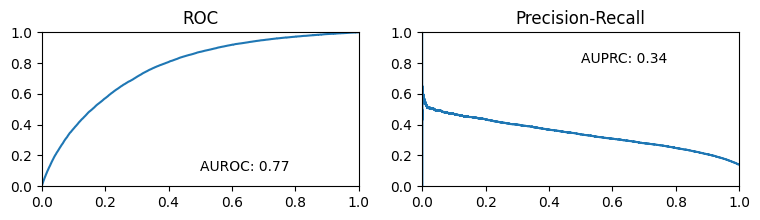

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench_stepaway_loo['auroc']['fpr'], bench_stepaway_loo['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench_stepaway_loo['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench_stepaway_loo['auprc']['recall'], bench_stepaway_loo['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench_stepaway_loo['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

LOO w/o stepaway

(0.0, 1.0)

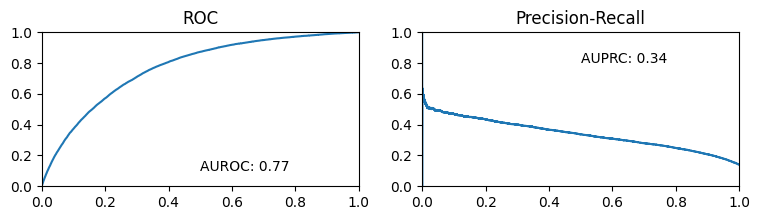

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench_loo['auroc']['fpr'], bench_loo['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench_loo['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench_loo['auprc']['recall'], bench_loo['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench_loo['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

Training data metrics

(0.0, 1.0)

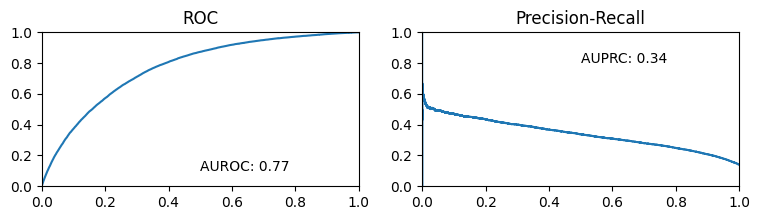

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench['auroc']['fpr'], bench['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench['auprc']['recall'], bench['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

In [26]:
bench['auroc']['auroc']

0.7714904826482973

In [27]:
params = lr_model.sample(128)
loo_out = []
for batch in tqdm(iter(data_factory())):
    loo_out += [lr_model.stepaway_loo(batch, params, step_size)]

0it [00:00, ?it/s]

240it [00:10, 23.67it/s]


In [31]:
eta = np.concatenate([t['eta_weights'] for t in loo_out], axis=-1)
nu = np.concatenate([t['nu_weights'] for t in loo_out], axis=-1)

In [32]:
eta_sd = tf.math.reduce_std(eta, axis=0)
nu_sd = tf.math.reduce_std(nu, axis=0)

In [40]:
plt.scatter(eta_sd, nu_sd)
x = np.linspace(min(eta_sd), max(eta_sd), 100)
plt.plot(x, x, linestyle='dashed')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f4790233520>,
 'caps': [<matplotlib.lines.Line2D at 0x7f4790113340>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f4790231330>],
 'medians': [<matplotlib.lines.Line2D at 0x7f4790113040>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f4790113880>],
 'means': []}

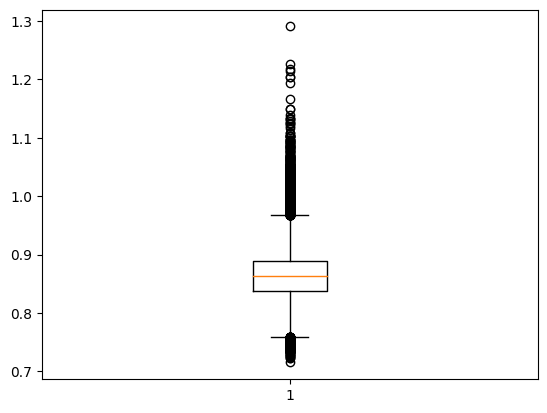

In [37]:
plt.boxplot(eta_sd/nu_sd)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f4790287f10>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f47902866b0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f4790411ab0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f4790412200>}

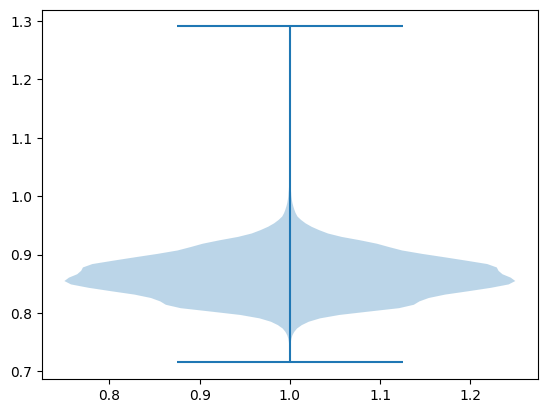

In [36]:
plt.violinplot(eta_sd/nu_sd)